<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/ALCF/AD_LTEM_PyTorch_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload

In [4]:
from routines.microscopes_fwd import *
from routines.img_helper import *

import torch
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
import numpy as np
import tifffile as tif
from matplotlib import pyplot, colors
import sys, time
from scipy import ndimage
from scipy.fftpack import *
import gdown
from scipy.signal import fftconvolve
import fabio
import scipy.constants as physcon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: NVIDIA RTX 6000 Ada Generation


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:

data_dir = "/home/ktrujillo/Lorentz/Kayna/ALTEM/NiFe/"
file_dir = "2023_10_09/TFS/aligned_imgj/"
stck_dir = "unflip/"
anly_dir = "analysis/"


In [7]:
fls = f"{data_dir}{file_dir}30kx_unflip.fls"
data = io.imread(f"{data_dir}{file_dir}{stck_dir}full_aligned_cropped.tif")

In [12]:
?data

Type:        ndarray
String form:
[[[4.2760e+03 3.4770e+03 2.8920e+03 ... 3.4101e+04 3.3111e+04 3.3022e+04]
           [4.8860e+03 3.8010e+0 <...> .7692e+04 3.7825e+04]
           [3.5542e+04 3.5515e+04 3.5361e+04 ... 3.7664e+04 3.7728e+04 3.8033e+04]]]
Length:      33
File:        ~/bin/anaconda3/envs/RMAD/lib/python3.10/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy`

# Import Dataset

In [9]:
import sys
import os
from PIL import Image
import math
from numpy.lib import scimath
from numpy import emath

In [11]:
expdata = fabio.open(f"{data_dir}{file_dir}{stck_dir}full_aligned_cropped.tif")

In [34]:
expdata.

33

## Set up the Object (Sample)

In [35]:
# Dimensions of object:
Nz = expdata.nframes    # number of images in stack
Ny = expdata.data.shape[0] # length of y-axis
Nx = expdata.data.shape[1] # length of x-axis
del_px = 0.00174025974e03  # nm/pixel
print("del_px:", del_px)

A_samples = np.zeros((Nz, Ny, Nx))
print("A_samples is of type:", type(A_samples))
print("A_samples is of shape:", A_samples.shape)    # verify the array


for ii in range(Nz):
  A_samples[ii] =  expdata.getframe(ii).data[:,:]#[1185:(1185+1350), 0:1350]



# np.where(A_samples == 0)
# np.where(A_samples < 0)

# print(A_samples)
A_samples = np.sqrt(np.abs(A_samples)) #np.emath.sqrt(A_samples) #np.sqrt(A_samples)

# normalize to the amplitude of the sample's experimental values
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis] 

del_px: 1.74025974
A_samples is of type: <class 'numpy.ndarray'>
A_samples is of shape: (33, 385, 385)


In [36]:
# Step 1: Open the text file for reading
file_path = fls  # Replace with your file path
with open(file_path, 'r') as file:
    
    # Step 2: Read the lines from the file and store them in a list
    lines = file.readlines()
    
    # Step 3: Reverse the order of the lines in the list
    lines.reverse()
    
    # Step 4: Parse the numerical values from the reversed lines
    numerical_values = []
    for line in lines:
        # Assuming the numerical values are separated by spaces, you can split the line by spaces
        values = line.strip().split()
        for value in values:
            try:
                numerical_values.append(float(value))
            except ValueError:
                pass  # Ignore non-numeric values

# Now, numerical_values contains the numerical values from the text file in reverse order
print(numerical_values) # nm

[300672.0, 211968.0, 150336.0, 1291600.0, 110016.0, 90432.0, 81216.0, 61632.0, 54144.0, 40320.0, 30528.0, 20160.0, 11520.0, 5760.0, 2880.0, 1728.0, 33.0]


In [53]:
OF = np.array(numerical_values)
UF = - OF
IF = 0.0
defocus = UF

defocus = np.append(arr=defocus, values=IF)
defocus = np.append(arr=defocus, values=OF)
defocus



array([-3.00672e+05, -2.11968e+05, -1.50336e+05, -1.29160e+06,
       -1.10016e+05, -9.04320e+04, -8.12160e+04, -6.16320e+04,
       -5.41440e+04, -4.03200e+04, -3.05280e+04, -2.01600e+04,
       -1.15200e+04, -5.76000e+03, -2.88000e+03, -1.72800e+03,
       -3.30000e+01,  0.00000e+00,  3.00672e+05,  2.11968e+05,
        1.50336e+05,  1.29160e+06,  1.10016e+05,  9.04320e+04,
        8.12160e+04,  6.16320e+04,  5.41440e+04,  4.03200e+04,
        3.05280e+04,  2.01600e+04,  1.15200e+04,  5.76000e+03,
        2.88000e+03,  1.72800e+03,  3.30000e+01])

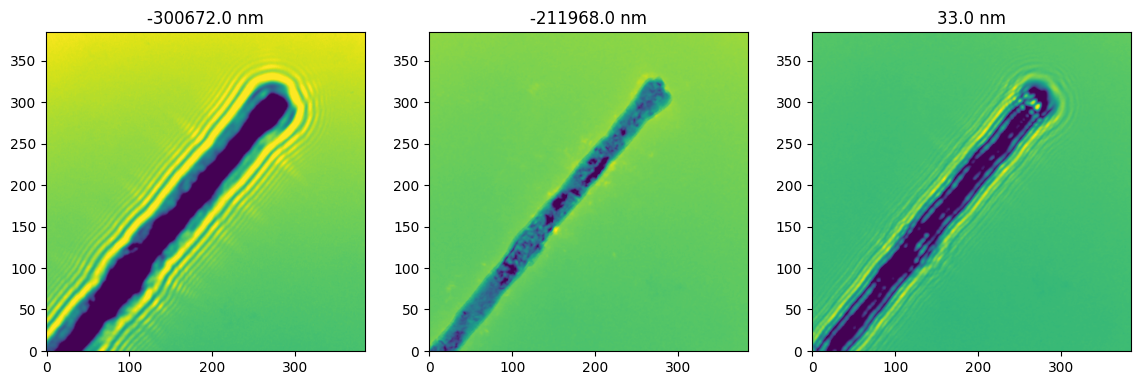

In [54]:
f, ax = pyplot.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', origin="lower")#, norm=colors.Normalize(A_samples[1].min(), A_samples[1].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[(len(A_samples)//2+1)], cmap='viridis', origin="lower", norm=colors.Normalize(A_samples[(len(A_samples)//2+1)].min(), A_samples[1].max()))
ax[1].set_title("{0} nm".format(defocus[1]))
ax[2].imshow(A_samples[-1], cmap='viridis', origin="lower")#, norm=colors.Normalize(A_samples[1].min(), A_samples[1].max()))
ax[2].set_title("{0} nm".format(defocus[-1]));

In [55]:
# rewriting the microscope transfer function with tensorflow
import scipy.constants as physcon

# Dimensions of the dataset are reciprocal space (dim) dimensions
[dim,dim] = A_samples[1].shape
# Dimensions of real space (d2) dimensions
d2 = dim/2
print("RECIPROCAL space is:", dim, "and REAL space is:", d2)

line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = torch.tensor(np.sqrt(X**2 + Y**2) / float(dim), 
                  dtype=torch.float32, 
                  requires_grad=True, 
                  device=device)

RECIPROCAL space is: 385 and REAL space is: 192.5


In [56]:
del_px = del_px #nm/px

E = 200.0e3 # kV
Cs = 1.0e6    
Cc = 5.0e6
Ca = 0.0e6
phi_a = 0.0
def_spr = 120

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

scale1 = 1
scale2 = 100

In [57]:
lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

In [58]:
def getTF(defoc, theta_c):

  def_val = defoc * scale1 / del_px

  theta_c = torch.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
 
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = torch.multiply(1.0/u, torch.multiply(p5, (p6 * qq**3 - torch.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = torch.exp(es_arg-et_arg)   # a tensor
  transfer_function = torch.fft.fftshift(torch.multiply(torch.complex(torch.cos(chiq),-torch.sin(chiq)), dampenv), dim=(1,2))
  
  return transfer_function

In [59]:
def compute_loss():
  tf_obj = guess_amplitude * torch.exp(1j*guess_phase)
  cal_data = torch.fft.ifft2(torch.fft.fft2(tf_obj)*getTF(defoc, theta_c))
  cal_data = torch.abs(cal_data)
  cal_data /= torch.mean(cal_data, dim=(1,2), keepdims=True)

  return torch.mean((cal_data - exp_data)**2)

In [60]:
def training_loop(optimizer, n=10000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = compute_loss()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.cpu().detach().numpy())  
        if i>0 and not i%10000:
          print(loss, theta_c)
    return losses

## BE SURE TO MODIFY GUESS AMPLITUDE AND GUESS PHASE in variable A_samples[n = "IF Image"]

In [61]:
## BE SURE TO MODIFY GUESS AMPLITUDE AND GUESS PHASE in variable A_samples[n = "IF Image"]

selection = [0, 1, 2, 17, -3, -2, -1]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = torch.from_numpy(A_samples[selection].astype(np.float32)).to(device)

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = torch.tensor(denoise_tv_chambolle(A_samples[(len(A_samples)//2+1)], 
                                                    weight=0.025, 
                                                    channel_axis=False), 
                                dtype=torch.float32, 
                                requires_grad=False, 
                                device=device)
# initialize the phase as 0.5 everywhere

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_phase = torch.tensor(np.zeros(A_samples[(len(A_samples)//2+1)].shape)+0.5, 
                           dtype=torch.float32, 
                           requires_grad=True, 
                           device=device) 
print(guess_phase.type(), guess_phase.dtype)

defoc = torch.tensor(defocus[selection][:, np.newaxis, np.newaxis]/scale1, 
                     dtype=torch.float32, 
                     requires_grad=False, 
                     device=device)
theta_c = torch.tensor(-500, dtype=torch.float32, requires_grad=False, device=device) 

opt = torch.optim.Adam([guess_phase], lr=0.025)

chosen defocus (mm):  [-3.00672e-01 -2.11968e-01 -1.50336e-01  0.00000e+00  2.88000e-03
  1.72800e-03  3.30000e-05]
torch.cuda.FloatTensor torch.float32


In [62]:
losses = training_loop(opt, n=200000)

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

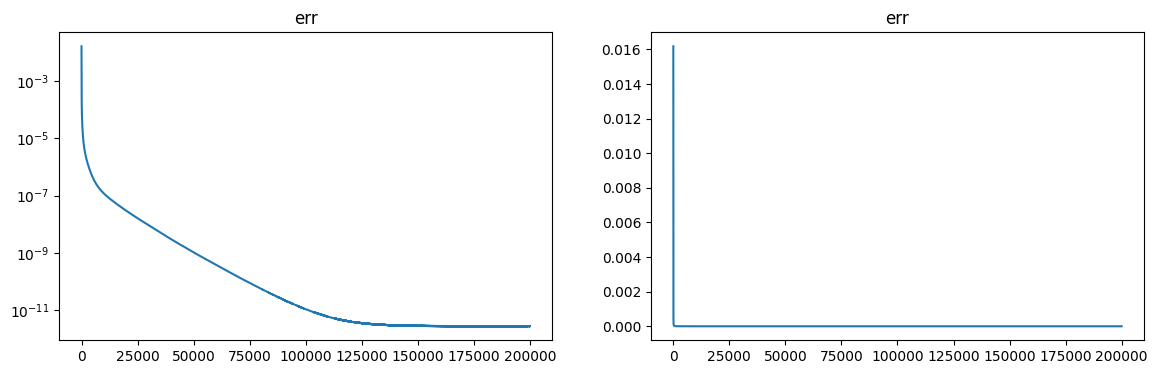

In [48]:
f, ax = pyplot.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(losses)
ax[0].set_title("err")
ax[1].plot(losses)
ax[1].set_title("err");

In [49]:
np.save(file="../../../Lorentz_Copies/Mumax_LTEM_SIM/2023_07_07/LTEM_sim_micro_2.7_512/df_100000/RMAD/mx3_micro_2.7nmppx_lr0.025_200000_losses_11m23s.npy",
        arr=losses,
        allow_pickle=False
        )

In [50]:
result_phase = guess_phase.cpu().detach().numpy()
result_phase -= result_phase.mean()

In [110]:
def show_im(
    image,
    title=None,
    simple=False,
    origin="upper",
    cbar=True,
    cbar_title="",
    scale=None,
    **kwargs,
):
    """Display an image on a new axis.

    Takes a 2D array and displays the image in grayscale with optional title on
    a new axis. In general it's nice to have things on their own axes, but if
    too many are open it's a good idea to close with plt.close('all').

    Args:
        image (2D array): Image to be displayed.
        title (str): (`optional`) Title of plot.
        simple (bool): (`optional`) Default output or additional labels.

            - True, will just show image.
            - False, (default) will show a colorbar with axes labels, and will adjust the
              contrast range for images with a very small range of values (<1e-12).

        origin (str): (`optional`) Control image orientation.

            - 'upper': (default) (0,0) in upper left corner, y-axis goes down.
            - 'lower': (0,0) in lower left corner, y-axis goes up.

        cbar (bool): (`optional`) Choose to display the colorbar or not. Only matters when
            simple = False.
        cbar_title (str): (`optional`) Title attached to the colorbar (indicating the
            units or significance of the values).
        scale (float): Scale of image in nm/pixel. Axis markers will be given in
            units of nanometers.

    Returns:
        None
    """
    fig, ax = plt.subplots()
    if not simple and np.max(image) - np.min(image) < 1e-12:
        # adjust coontrast range
        vmin = np.min(image) - 1e-12
        vmax = np.max(image) + 1e-12
        im = ax.matshow(image, cmap="gray", origin=origin, vmin=vmin, vmax=vmax)
    else:
        im = ax.matshow(image, cmap="gray", origin=origin, **kwargs)

    if title is not None:
        ax.set_title(str(title), pad=0)

    if simple:
        plt.axis("off")
    else:
        plt.tick_params(axis="x", top=False)
        ax.xaxis.tick_bottom()
        ax.tick_params(direction="in")
        if scale is None:
            ticks_label = "pixels"
        else:

            def mjrFormatter(x, pos):
                return f"{scale*x:.3g}"

            fov = scale * max(image.shape[0], image.shape[1])

            if fov < 4e3:  # if fov < 4um use nm scale
                ticks_label = " nm "
            elif fov > 4e6:  # if fov > 4mm use m scale
                ticks_label = "  m  "
                scale /= 1e9
            else:  # if fov between the two, use um
                ticks_label = " $\mu$m "
                scale /= 1e3

            ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
            ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))

        if origin == "lower":
            ax.text(y=0, x=0, s=ticks_label, rotation=-45, va="top", ha="right")
        elif origin == "upper":  # keep label in lower left corner
            ax.text(
                y=image.shape[0], x=0, s=ticks_label, rotation=-45, va="top", ha="right"
            )

        if cbar:
            plt.colorbar(im, ax=ax, pad=0.02, format="%.2g", label=str(cbar_title))

    plt.show()
    return

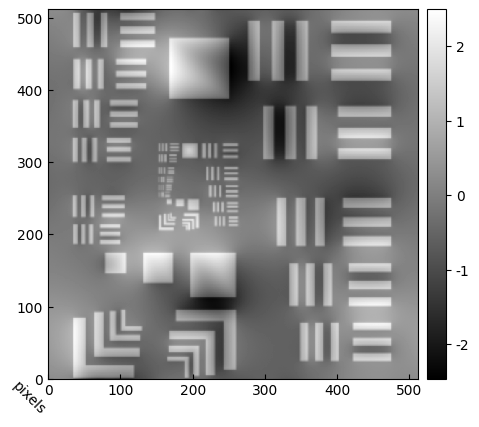

In [51]:
show_im(result_phase, origin="lower")
from tifffile import imwrite
import numpy as np

imwrite("../../../Lorentz_Copies/Mumax_LTEM_SIM/2023_07_07/LTEM_sim_micro_2.7_512/df_100000/RMAD/mx3_micro_2.7nmppx_lr0.025_200000_resultsphase.tif", result_phase)

# imwrite("/home/ktrujillo/Lorentz/Kayna/Simulations/Mumax3/2023_04_26/results_nano.tiff", result_phase)
# imwrite("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_18/TIE/usaf_/aligned_imgj/images/RMAD/usaf_nano_AD_RAW_200000.tiff", result_phase)

In [ ]:
from routines.img_helper import *
p = result_phase
fftp = get_fft(p)
del_px = del_px
print(del_px)

filter_lf = None #2500 # nm
filter_hf = 12.50 # 2500 # nm

dim_y, dim_x = p.shape

x_sampling = y_sampling = 1 / del_px  # [pixels/nm]
u_max = x_sampling / 2
v_max = y_sampling / 2
u_axis_vec = np.linspace(-u_max / 2, u_max / 2, dim_x)
v_axis_vec = np.linspace(-v_max / 2, v_max / 2, dim_y)
u_mat, v_mat = np.meshgrid(u_axis_vec, v_axis_vec)
r = np.sqrt(u_mat**2 + v_mat**2)  # nm

if filter_lf is not None:
    inverse_gauss_filter = 1 - np.exp(-1 * (r * filter_lf) ** 2)
else:
    inverse_gauss_filter = np.ones_like(r)
if filter_hf is not None:
    gauss_filter = np.exp(-1 * (r * filter_hf) ** 2)
else:
    gauss_filter = np.ones_like(r)
bp_filter = inverse_gauss_filter * gauss_filter

bp_fftp = fftp*bp_filter
kp = get_ifft(bp_fftp).real

show_im(kp, scale=del_px)

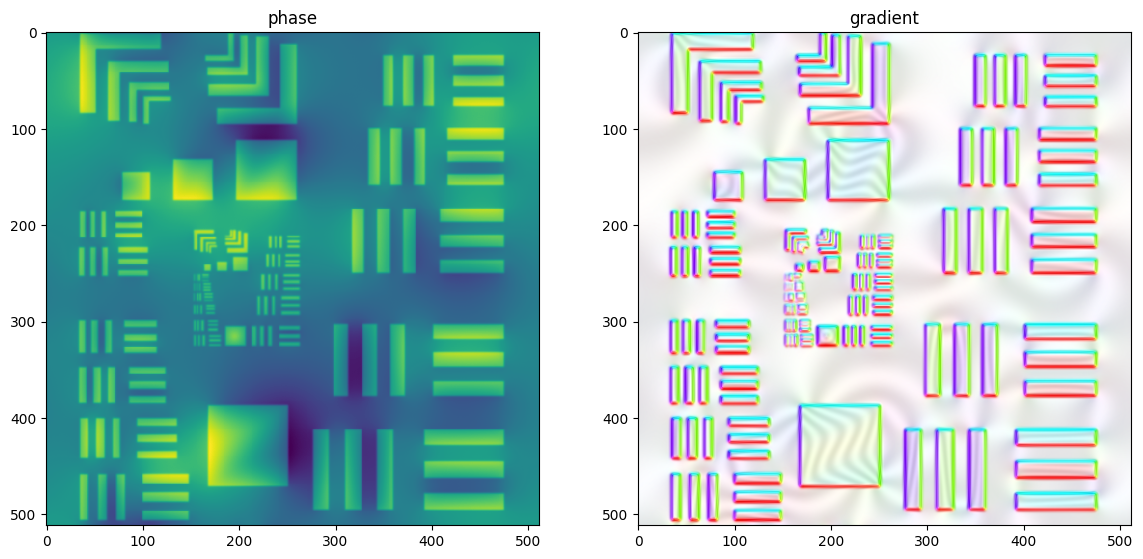

In [52]:
# !gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

# from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = pyplot.subplots(ncols=2, 
                        figsize = (14,8))

ax[0].imshow(result_phase, 
             interpolation='none', 
             cmap='viridis',
            #  origin="lower"
             )
ax[0].set_title("phase")

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),
                           sigma=1.0,
                           order=0)

gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)

rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)

ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), 
             cmap='gray', 
             alpha=0.1, 
             vmin=-1, 
             vmax=1,
            #  origin="lower"
            )
ax[1].set_title("gradient");
# plt.savefig("/home/ktrujillo/Lorentz_Copies/ADLTEM_analysis/mumax3_usaf_nano0.7_1.4nmppx_lr0.025_sigma2.5.png")
# plt.savefig("/home/ktrujillo/Lorentz_Copies/ADLTEM_analysis/exp_usaf_micro_lr0.00025_sigma2.5.png")

## Import RAW DATA Individually

In [ ]:
from skimage import io
p = io.imread("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_18/TIE/usaf_micro/aligned_imgj/images/RMAD/usaf_micro_AD_RAW.tiff")

show_im(p)
plt.imshow(p, cmap="gray")
